In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/datasets/rsna_bitirme.zip



Görüntülenen çıkış son 5000 satıra kısaltıldı.
   creating: rsna_bitirme/40341/
  inflating: rsna_bitirme/40341/['LCC'].png  
  inflating: rsna_bitirme/40341/['LMLO'].png  
  inflating: rsna_bitirme/40341/['RCC'].png  
  inflating: rsna_bitirme/40341/['RMLO'].png  
   creating: rsna_bitirme/40362/
  inflating: rsna_bitirme/40362/['LCC'].png  
  inflating: rsna_bitirme/40362/['LMLO'].png  
  inflating: rsna_bitirme/40362/['RCC'].png  
  inflating: rsna_bitirme/40362/['RMLO'].png  
   creating: rsna_bitirme/40397/
  inflating: rsna_bitirme/40397/['LCC'].png  
  inflating: rsna_bitirme/40397/['LMLO'].png  
  inflating: rsna_bitirme/40397/['RCC'].png  
  inflating: rsna_bitirme/40397/['RMLO'].png  
   creating: rsna_bitirme/40410/
  inflating: rsna_bitirme/40410/['LCC'].png  
  inflating: rsna_bitirme/40410/['LMLO'].png  
  inflating: rsna_bitirme/40410/['RCC'].png  
  inflating: rsna_bitirme/40410/['RMLO'].png  
   creating: rsna_bitirme/40444/
  inflating: rsna_bitirme/40444/['LCC'].png 

In [ ]:
import tensorflow as tf

# tf.compat.v1.enable_eager_execution(
#     config=None, device_policy=None, execution_mode=None)
tf.config.run_functions_eagerly(True)

import os
import cv2

import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.optimizers import SGD,Adam

from keras.utils import img_to_array

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/drive/MyDrive/datasets/rsna_bitirme2.csv')



df['density'] = df['density'].replace('A',0.)
df['density'] = df['density'].replace('B',1.)
df['density'] = df['density'].replace('C',2.)
df['density'] = df['density'].replace('D',3.)


df['BIRADS'] = df['BIRADS'].replace('2',1.)
df['BIRADS'] = df['BIRADS'].replace('1',0.)
df['BIRADS'] = df['BIRADS'].replace('4-5',2.)

uni = list(df[df['BIRADS'] == 0.]['patient_id'].unique())

import random

inn = random.sample(uni, k = 1400)
inn = inn + inn + inn + inn
for index,item in enumerate(df['patient_id']):
  # print(item)
  if item in inn:
    # print(item)
    df.drop(index = index,axis=0,inplace= True) 



from sklearn.model_selection import train_test_split
values = list(df['density'].values)
b_values = list(df['BIRADS'].values)

v= {'birads_out':b_values, 'dense_values':values}
d = pd.DataFrame(v)

data = list(df['patient_id'].values)

  
X_train, X_test, y_train, y_test = train_test_split(data, list(d.values),
                                                    test_size=0.10,
                                                    random_state=42,
                                                    stratify=b_values)


In [ ]:
df.BIRADS.value_counts()

2.0    1212
1.0     960
0.0     644
Name: BIRADS, dtype: int64

In [ ]:
from google.colab.patches import cv2_imshow
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
x = []
for i in X_train:

  x.append(glob.glob(f"/content/rsna_bitirme/{i}/*.png"))

x1,x2,x3,x4 = [],[],[],[]
for i in range(0,len(x)):
  
  x1.append(x[i][0])
  x2.append(x[i][1])
  x3.append(x[i][2])
  x4.append(x[i][3])

In [ ]:
x1[:4]

["/content/rsna_bitirme/59530/['RCC'].png",
 "/content/rsna_bitirme/48368/['RCC'].png",
 "/content/rsna_bitirme/47382/['RCC'].png",
 "/content/rsna_bitirme/34667/['RCC'].png"]

In [ ]:
y_train[:4]

array([[2., 2.],
       [2., 2.],
       [2., 1.],
       [0., 2.]])

In [ ]:
x2[:4]

["/content/rsna_bitirme/59530/['RMLO'].png",
 "/content/rsna_bitirme/48368/['RMLO'].png",
 "/content/rsna_bitirme/47382/['RMLO'].png",
 "/content/rsna_bitirme/34667/['RMLO'].png"]

bos degerlere en fazla olan diger degeri ata demek hatali olabilir. Birde bos degerlere 1 etikeri vurmayidene ama bu unbalance sorunu doguracaktir. en mantiklisi her hastayi tek degere indirgemek olabilir.

(512, 512, 1)


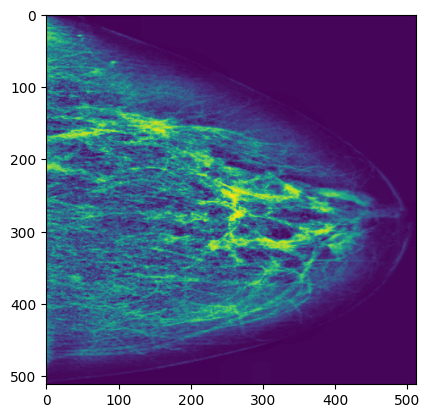

In [ ]:
from google.colab.patches import cv2_imshow
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
x = []
for i in X_train:

  x.append(glob.glob(f"/content/rsna_bitirme/{i}/*.png"))

x1,x2,x3,x4 = [],[],[],[]
for i in range(0,len(x)):
  
  x1.append(x[i][0])
  x2.append(x[i][1])
  x3.append(x[i][2])
  x4.append(x[i][3])

def read_and_decode(filename):

  img = tf.io.read_file(filename)

  img = tf.image.decode_png(img, channels = None)
  img = tf.cast(img, tf.float16) /255.
  # img = tf.image.convert_image_dtype(img, tf.float32)
  
  # img = tf.image.resize(img,reshape_dims)
  return img

def show_img(filename):
  
  img = read_and_decode(filename) 
  print(img.shape)
  plt.imshow(img.numpy())
  

show_img(x1[:1][0])


In [ ]:
# tf.enable_eager_execution(config=None, device_policy=None, execution_mode=None)

from glob import glob
import random

from keras.utils import to_categorical
import glob
import gc 

gc.collect()  

x = []
for i in X_train:

  x.append(glob.glob(f"/content/rsna_bitirme/{i}/*.png"))

x1,x2,x3,x4 = [],[],[],[]
for i in range(0,len(x)):
  
  x1.append(x[i][0])
  x2.append(x[i][1])
  x3.append(x[i][2])
  x4.append(x[i][3])


# trainLabels = to_categorical(y_train)
b = []
d = []

for i in y_train:
  b.append(i[0])
  d.append(i[1])

b = to_categorical(b)
d = to_categorical(d)

b = b.astype('float32')
d = d.astype('float32')

trainLabels = {'birads':b,'yogunluk':d}




def make_dataset( x1,x2,x3,x4,yTrain ,batch_size):


  def parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels = None)
    img = tf.cast(img, tf.float16) /255.  
    # img = tf.image.resize(img,reshape_dims)
    return img

  def configure_for_performance(ds):
    # ds = ds.shuffle(buffer_size=1000)
    ds = ds.cache()
    ds = ds.batch(batch_size)
    # ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds
  

  
  

  list_ds1 = tf.data.Dataset.from_tensor_slices(x1)
  list_ds2 = tf.data.Dataset.from_tensor_slices(x2)
  list_ds3 = tf.data.Dataset.from_tensor_slices(x3)
  list_ds4 = tf.data.Dataset.from_tensor_slices(x4)


  images_ds1 = list_ds1.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  images_ds2 = list_ds2.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  images_ds3 = list_ds3.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  images_ds4 = list_ds4.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  

  trainLabels = tf.data.Dataset.from_tensor_slices(yTrain)

  images_ds = tf.data.Dataset.zip((images_ds1, images_ds2,images_ds3,images_ds4))
  ds = tf.data.Dataset.zip((images_ds, trainLabels))
  ds = configure_for_performance(ds)
  # import gc 
  # gc.collect()
  return ds


# ------------------------------TEST---------------------------------

x = []
for i in X_test:

  x.append(glob.glob(f"/content/rsna_bitirme/{i}/*.png"))

x11,x22,x33,x44 = [],[],[],[]
for i in range(0,len(x)):
    
  x11.append(x[i][0])
  x22.append(x[i][1])
  x33.append(x[i][2])
  x44.append(x[i][3])


def make_test(x1,x2,x3,x4 ,batch_size):

  def parse_image(filename):
    img = tf.io.read_file(filename)

    img = tf.image.decode_png(img, channels = None)
    img = tf.cast(img, tf.float16) /255.
    
    # img = tf.image.resize(img,reshape_dims)
    return img

  def configure_for_performance(ds):
    # ds = ds.shuffle(buffer_size=1000)
    # ds = ds.cache()
    ds = ds.batch(batch_size)
    # ds = ds.repeat()
    # ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds
  

  list_ds1 = tf.data.Dataset.from_tensor_slices(x1)
  list_ds2 = tf.data.Dataset.from_tensor_slices(x2)
  list_ds3 = tf.data.Dataset.from_tensor_slices(x3)
  list_ds4 = tf.data.Dataset.from_tensor_slices(x4)


  images_ds1 = list_ds1.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  images_ds2 = list_ds2.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  images_ds3 = list_ds3.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  images_ds4 = list_ds4.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  

  ds = tf.data.Dataset.zip((images_ds1, images_ds2,images_ds3,images_ds4))
  ds = tf.data.Dataset.zip((ds,()))
  
  ds = configure_for_performance(ds)

  
  return ds




trainDS = make_dataset(x1,x2,x3,x4,trainLabels,4)
# valDS = make_dataset(x111,x222,x333,x444,trainval,2)
testDS = make_test(x11,x22,x33,x44 ,8)

In [ ]:
from keras.models import Sequential
from keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        # layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
#  -------------------------------Breast-Wise--------------------------------------
def ResNet34(img_shape):
  def identity_block(x, filter):
      # copy tensor to variable called x_skip
      x_skip = x
      # Layer 1
      x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization(axis=3)(x)
      x = tf.keras.layers.Activation('relu')(x)
      # Layer 2
      x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization(axis=3)(x)
      # Add Residue
      x = tf.keras.layers.Add()([x, x_skip])     
      x = tf.keras.layers.Activation('relu')(x)
      return x



  def convolutional_block(x, filter):
      # copy tensor to variable called x_skip
      x_skip = x
      # Layer 1
      x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
      x = tf.keras.layers.BatchNormalization(axis=3)(x)
      x = tf.keras.layers.Activation('relu')(x)
      # Layer 2
      x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
      x = tf.keras.layers.BatchNormalization(axis=3)(x)
      # Processing Residue with conv(1,1)
      x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
      # Add Residue
      x = tf.keras.layers.Add()([x, x_skip])     
      x = tf.keras.layers.Activation('relu')(x)
      return x




    # Step 1 (Setup Input Layer)
  inputA = Input(shape=(img_shape))   # 3 ler silindi (layer)
  # inputA = img_augmentation(inputA)
  x = tf.keras.layers.ZeroPadding2D((3, 3))(inputA)
  # Step 2 (Initial Conv layer along with maxPool)
  x = tf.keras.layers.Conv2D(16, kernel_size=7, strides=2, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #       tf.keras.layers.Dropout(rate=dropout_prob, name='dropout_dense_{}'.format(hno)), ])  EKLENEBILIR
  x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
  # Define size of sub-blocks and initial filter size
  block_layers = [3, 4, 6, 3]
  filter_size = 16
  # Step 3 Add the Resnet Blocks
  for i in range(4):
      if i == 0:
          # For sub-block 1 Residual/Convolutional block not needed
          for j in range(block_layers[i]):
              x = identity_block(x, filter_size)
      else:
          # One Residual/Convolutional Block followed by Identity blocks
          # The filter size will go on increasing by a factor of 2
          filter_size = filter_size*2
          x = convolutional_block(x, filter_size)
          for j in range(block_layers[i] - 1):
              x = identity_block(x, filter_size)
  output_A = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)    # MaxPooking2D denenebilir
  # output_A = Dense(100, activation = 'relu')(output_A)
  # output_A = Dropout(0.2)(output_A)
  # output_A = tf.keras.layers.Flatten()(output_A)
  del x


  inputB = Input(shape=(img_shape))   # 3 ler silindi (layer)
  # inputB = img_augmentation(inputB)
  x = tf.keras.layers.ZeroPadding2D((3, 3))(inputB)
  # Step 2 (Initial Conv layer along with maxPool)
  x = tf.keras.layers.Conv2D(16, kernel_size=7, strides=2, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
  # Define size of sub-blocks and initial filter size
  block_layers = [3, 4, 6, 3]
  filter_size = 16
  # Step 3 Add the Resnet Blocks
  for i in range(4):
      if i == 0:
          # For sub-block 1 Residual/Convolutional block not needed
          for j in range(block_layers[i]):
              x = identity_block(x, filter_size)
      else:
          # One Residual/Convolutional Block followed by Identity blocks
          # The filter size will go on increasing by a factor of 2
          filter_size = filter_size*2
          x = convolutional_block(x, filter_size)
          for j in range(block_layers[i] - 1):
              x = identity_block(x, filter_size)
  output_B = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
  # output_B = Dense(100, activation = 'relu')(output_B)
  # output_B = Dropout(0.2)(output_B)
  # output_B = tf.keras.layers.Flatten()(output_B)
  del x


  inputC = Input(shape=(img_shape))   # 3 ler silindi (layer)
  # inputC = img_augmentation(inputC)
  x = tf.keras.layers.ZeroPadding2D((3, 3))(inputC)
  # Step 2 (Initial Conv layer along with maxPool)
  x = tf.keras.layers.Conv2D(16, kernel_size=7, strides=2, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
  # Define size of sub-blocks and initial filter size
  block_layers = [3, 4, 6, 3]
  filter_size = 16
  # Step 3 Add the Resnet Blocks
  for i in range(4):
      if i == 0:
          # For sub-block 1 Residual/Convolutional block not needed
          for j in range(block_layers[i]):
              x = identity_block(x, filter_size)
      else:
          # One Residual/Convolutional Block followed by Identity blocks
          # The filter size will go on increasing by a factor of 2
          filter_size = filter_size*2
          x = convolutional_block(x, filter_size)
          for j in range(block_layers[i] - 1):
              x = identity_block(x, filter_size)
  output_C = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
  # output_C = Dense(100, activation = 'relu')(output_C)
  # output_C = Dropout(0.2)(output_C)
  # output_C = tf.keras.layers.Flatten()(output_C)
  del x


  inputD = Input(shape=(img_shape))   # 3 ler silindi (layer)
  # inputD = img_augmentation(inputD)
  x = tf.keras.layers.ZeroPadding2D((3, 3))(inputD)
  # Step 2 (Initial Conv layer along with maxPool)
  x = tf.keras.layers.Conv2D(16, kernel_size=7, strides=2, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
  # Define size of sub-blocks and initial filter size
  block_layers = [3, 4, 6, 3]
  filter_size = 16
  # Step 3 Add the Resnet Blocks
  for i in range(4):
      if i == 0:
          # For sub-block 1 Residual/Convolutional block not needed
          for j in range(block_layers[i]):
              x = identity_block(x, filter_size)
      else:
          # One Residual/Convolutional Block followed by Identity blocks
          # The filter size will go on increasing by a factor of 2
          filter_size = filter_size*2
          x = convolutional_block(x, filter_size)
          for j in range(block_layers[i] - 1):
              x = identity_block(x, filter_size)
  output_D = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
  # output_D = Dense(100, activation = 'relu')(output_D)
  # output_D = Dropout(0.2)(output_D)
  # output_D = tf.keras.layers.Flatten()(output_D)
  del x

  # Step 4 End Dense Network,kernel_regularizer=tf.keras.regularizers.L2(l2=0.05
  combined_AB = keras.layers.concatenate([output_A, output_B])
  combined_AB = Dense(10, activation = 'relu')(combined_AB)
  combined_AB = Dense(10, activation = 'relu')(combined_AB)
  combined_AB = Dropout(0.2)(combined_AB)


  combined_AB = tf.keras.layers.Flatten()(combined_AB)
  cc_Birads = Dense(3, activation='softmax')(combined_AB) # Birads 
  cc_Dense = Dense(4, activation='softmax')(combined_AB) # DENSE

  

  combined_CD = keras.layers.concatenate([output_C, output_D])

  combined_CD = Dense(10, activation = 'relu')(combined_CD)
  combined_CD = Dense(10, activation = 'relu')(combined_CD)
  combined_CD = Dropout(0.2)(combined_CD)

  combined_CD = tf.keras.layers.Flatten()(combined_CD)

  mlo_Birads = Dense(3, activation='softmax')(combined_CD) 
  mlo_Dense = Dense(4, activation='softmax')(combined_CD) # DENSE


  output_Birads = tf.keras.layers.Average(name = 'birads')([cc_Birads, mlo_Birads])
  output_Dense = tf.keras.layers.Average(name = 'yogunluk')([cc_Dense, mlo_Dense])


  model = Model(inputs=[inputA , inputB,inputC,inputD] , outputs=[output_Birads, output_Dense])  # [inputA , inputB,inputC,inputD]

  return model  


INPUT_SHAPE = 512, 512,1


model = ResNet34(INPUT_SHAPE)

model.compile(loss = [{'birads':'categorical_crossentropy','yogunluk':'categorical_crossentropy'}],  #categorical_crossentropy
            optimizer = Adam(learning_rate=1e-4),     # Adam(learning_rate=1e-3)
            metrics = {'birads':'accuracy','yogunluk':'accuracy'})

In [ ]:
tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [ ]:
import gc 
gc.collect()

96

In [ ]:
H = model.fit(
					x=trainDS,
					epochs=3)

Epoch 1/3
634/634 [==============================] - 504s 777ms/step - loss: 1.5550 - birads_loss: 0.8670 - yogunluk_loss: 0.6880 - birads_accuracy: 0.6204 - yogunluk_accuracy: 0.7309
Epoch 2/3
634/634 [==============================] - 462s 729ms/step - loss: 0.6138 - birads_loss: 0.3423 - yogunluk_loss: 0.2715 - birads_accuracy: 0.9053 - yogunluk_accuracy: 0.9081
Epoch 3/3
634/634 [==============================] - 459s 724ms/step - loss: 0.1794 - birads_loss: 0.0938 - yogunluk_loss: 0.0857 - birads_accuracy: 0.9937 - yogunluk_accuracy: 0.9830


In [ ]:
ypred = model.predict(testDS)

bPred = ypred[0]
dPred = ypred[1]


b = []
d = []

for i in y_test:
  b.append(i[0])
  d.append(i[1])


b = to_categorical(b)
d = to_categorical(d)


b = b.astype('float32')
d = d.astype('float32')

trainLabels = {'birads':b,'yogunluk':d}


total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(bPred)):

    if np.argmax(bPred[i]) == np.argmax(b[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

# 199/199 [==============================] - 49s 224ms/step
# Total-test-data; 796 	accurately-predicted-data: 449 	 wrongly-predicted-data:  347
# Accuracy: 56.407 %

# 199/199 [==============================] - 48s 244ms/step
# Total-test-data; 796 	accurately-predicted-data: 392 	 wrongly-predicted-data:  404
# Accuracy: 49.246 %

36/36 [==============================] - 14s 361ms/step
Total-test-data; 282 	accurately-predicted-data: 279 	 wrongly-predicted-data:  3
Accuracy: 98.936 %


Text(0.5, 118.72222222222216, 'Predicted')

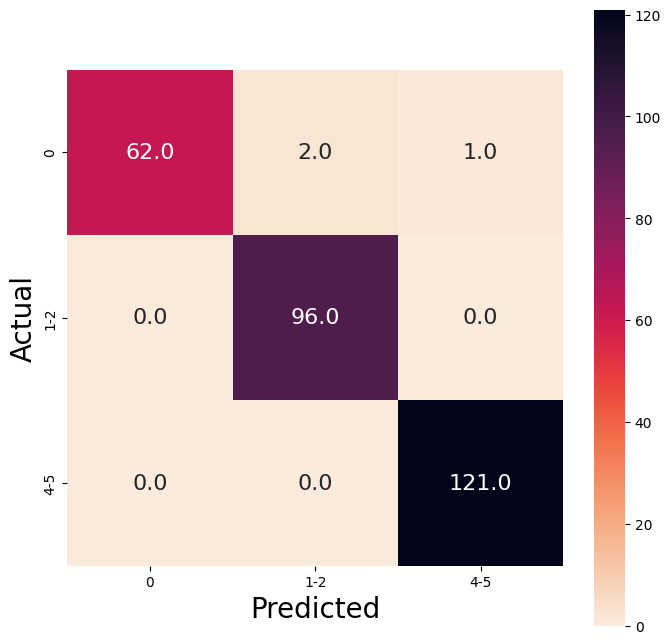

In [ ]:
 
from sklearn.metrics import confusion_matrix
import seaborn as sns
label = ['0','1-2','4-5']
Ypred = np.argmax(bPred, axis=1)
Ytrue = np.argmax(b, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(dPred)):

    if np.argmax(dPred[i]) == np.argmax(d[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

# Total-test-data; 796 	accurately-predicted-data: 417 	 wrongly-predicted-data:  379
# Accuracy: 52.387 %

Total-test-data; 282 	accurately-predicted-data: 276 	 wrongly-predicted-data:  6
Accuracy: 97.872 %


Text(0.5, 192.72222222222217, 'Predicted')

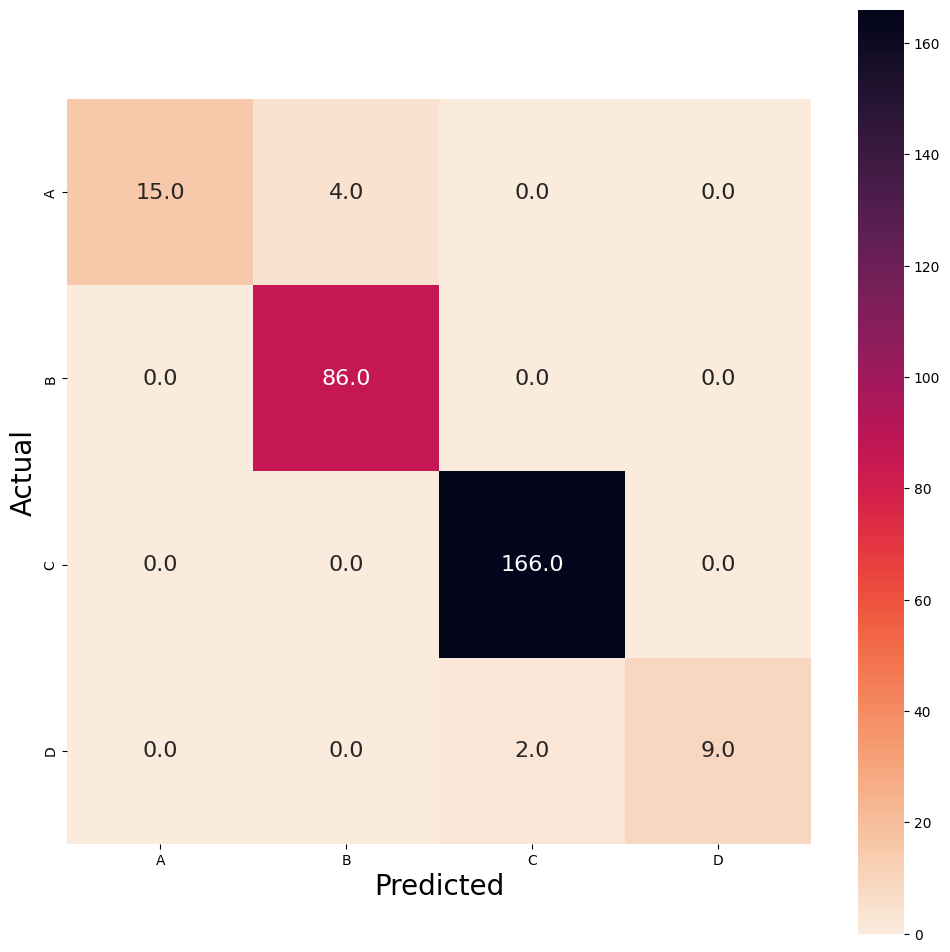

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
label = ['A','B','C','D']
Ypred = np.argmax(dPred, axis=1)
Ytrue = np.argmax(d, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [ ]:
# # Helper functions
# def training_plot(metrics, history):
#   f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
#   for idx, metric in enumerate(metrics):
#     ax[idx].plot(history.history[metric], ls='dashed')
#     ax[idx].set_xlabel("Epochs")
#     ax[idx].set_ylabel(metric)
#     ax[idx].plot(history.history['val_' + metric]);
#     ax[idx].legend([metric, 'val_' + metric])

# # Call model.predict() on a few images in the evaluation dataset
# def plot_predictions(filename):
#   f, ax = plt.subplots(3, 5, figsize=(25,15))
#   dataset = (tf.data.TextLineDataset(filename).
#       map(decode_csv))
#   for idx, (img, label) in enumerate(dataset.take(15)):
#     ax[idx//5, idx%5].imshow((img.numpy()));
#     batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
#     batch_pred = model.predict(batch_image)
#     pred = batch_pred[0]
#     label = CLASS_NAMES[label.numpy()]
#     pred_label_index = tf.math.argmax(pred).numpy()
#     pred_label = CLASS_NAMES[pred_label_index]
#     prob = pred[pred_label_index]
#     ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

# def show_trained_weights(model):
#   # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
#   LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
#   WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

#   f, ax = plt.subplots(1, 5, figsize=(15,15))
#   for flower in range(len(CLASS_NAMES)):
#     weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
#     min_wt = tf.math.reduce_min(weights).numpy()
#     max_wt = tf.math.reduce_max(weights).numpy()
#     flower_name = CLASS_NAMES[flower]
#     print("Scaling weights for {} in {} to {}".format(
#         flower_name, min_wt, max_wt))
#     weights = (weights - min_wt)/(max_wt - min_wt)
#     ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
#     ax[flower].set_title(flower_name);




# training_plot(['loss', 'accuracy'], history)

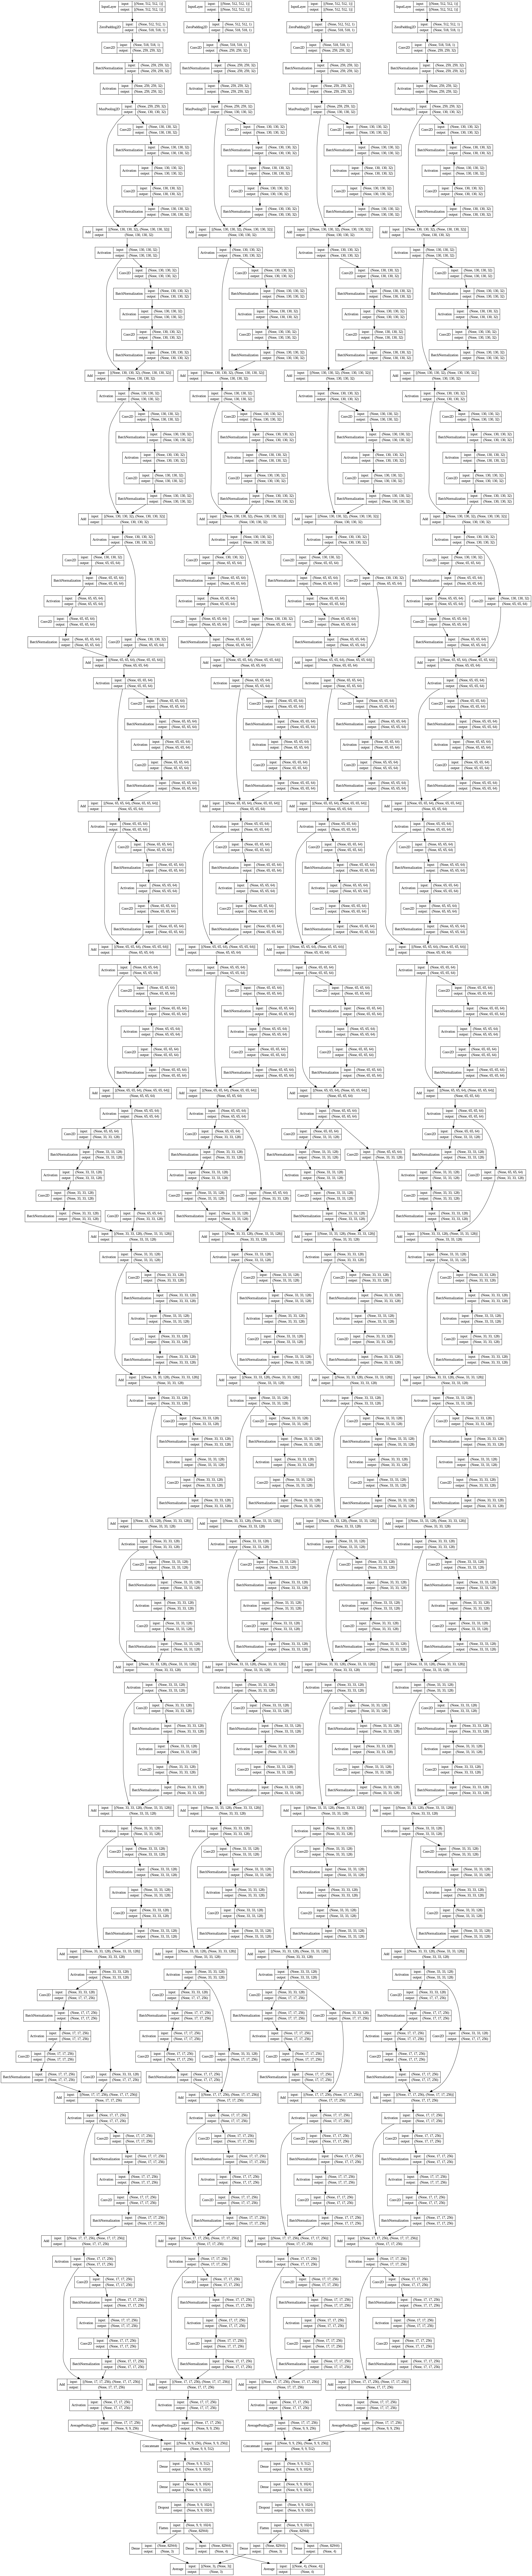

In [ ]:
tf.keras.utils.plot_model(model, show_shapes= True, show_layer_names = False)

In [ ]:
# import matplotlib
# matplotlib.rcParams.update({'font.size': 20})
# def training_plot(metrics, history):
#     f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
#     for idx, metric in enumerate(metrics):
#         ax[idx].plot(history.history[metric])
#         ax[idx].set_xlabel("Epochs")
#         # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
#         ax[idx].plot(history.history['val_' + metric], ls='dashed');
#         ax[idx].legend([metric, 'val_' + metric], fontsize=20)

# training_plot(['loss', 'accuracy'], history)

In [ ]:
# # Call model.predict() on a few images in the evaluation dataset
# def plot_predictions(filename):
#   matplotlib.rcParams.update({'font.size': 14})
#   f, ax = plt.subplots(3, 5, figsize=(25,15))
#   dataset = (tf.data.TextLineDataset(filename).
#       map(parse_csvline))
#   for idx, (img, label) in enumerate(dataset.take(15)):
#     ax[idx//5, idx%5].imshow((img.numpy()));
#     batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
#     batch_pred =model.predict(batch_image) # TODO 3 -- Your code here
#     pred = batch_pred[0]
#     label = CLASS_NAMES[label.numpy()]
#     pred_label_index = tf.math.argmax(pred).numpy()
#     pred_label = CLASS_NAMES[pred_label_index]
#     prob = pred[pred_label_index]
#     ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
#     ax[idx//5, idx%5].axis('off')

# plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv")

In [ ]:
/